# Generate MNIST dataset on a black canvas

## Generate the artificial dataset

### Imports

In [12]:
import os
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.5.0


### Parameters

In [13]:
NEW_IMG_SIZE = 160
MAX_DATA = 200
N_BOXES = 3

### Visualization Utilities

These functions are used to draw bounding boxes around the digits.

In [14]:
use_normalized_coordinates = True
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness,
                               display_str_list)
  return np.array(rgbimg)
  

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2],  thickness)
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  NEW_IMG_SIZE, NEW_IMG_SIZE = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * NEW_IMG_SIZE, xmax * NEW_IMG_SIZE,
                                  ymin * NEW_IMG_SIZE, ymax * NEW_IMG_SIZE)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  


In [15]:

'''
Transforms each image in dataset by pasting it on a NEW_IMG_SIZExNEW_IMG_SIZE canvas at random locations.
'''
def draw_on_canvas(images_numpy):
    imgs = []
    bboxes = []
    for image_numpy in images_numpy:
        image = tf.convert_to_tensor(image_numpy)
        xmin = tf.random.uniform((), 0 , NEW_IMG_SIZE - 28 - 3, dtype=tf.int32)
        ymin = tf.random.uniform((), 0 , NEW_IMG_SIZE - 28 - 3, dtype=tf.int32)
        image = tf.reshape(image, (28,28,1,))
        image = tf.image.pad_to_bounding_box(image, ymin, xmin, NEW_IMG_SIZE, NEW_IMG_SIZE)
    
        image = tf.cast(image, tf.float32)/255.0
        
        
        #image = 1 - image
        #image += tf.random.uniform((NEW_IMG_SIZE, NEW_IMG_SIZE, 1), minval=0, maxval=0.1)
    
        xmin = tf.cast(xmin, tf.float32)
        ymin = tf.cast(ymin, tf.float32)
   
        xmax = (xmin + 28) / NEW_IMG_SIZE
        ymax = (ymin + 28) / NEW_IMG_SIZE
        xmin = xmin / NEW_IMG_SIZE
        ymin = ymin / NEW_IMG_SIZE

        imgs.append(image)
        box = np.array([xmin, ymin, xmax, ymax])
        bboxes.append(box)


    return (sum(imgs)).numpy(), np.array(bboxes)


In [16]:
def get_train_test(max_data=100):
    ds_train = tfds.load(name="mnist", split="train")
    ds_numpy = tfds.as_numpy(ds_train)
    images = []
    train_labels = []
    for i, data in enumerate(ds_numpy):
        if i > max_data:
            break
        images.append(data["image"])
        train_labels.append(data["label"])
    
    return np.array(images), np.array(train_labels)
    
def generate_bboxes(ds_numpy, labels_np, max_data=100):
    images = []
    bboxes = []
    labels = []

    for i in range(max_data):
        idx = np.random.choice(MAX_DATA, N_BOXES)
        imgs = ds_numpy[idx]
        img, boxes = draw_on_canvas(imgs)

        images.append(img)
        bboxes.append(boxes)
        labels.append(labels_np[idx])
        
        
    return np.array(images), np.array(bboxes), np.array(labels)

In [17]:
images, labels = get_train_test(max_data=MAX_DATA)
images.shape, labels.shape

2021-11-23 08:29:51.397399: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


((201, 28, 28, 1), (201,))

In [18]:
images, bboxes, labels = generate_bboxes(images, labels, max_data=MAX_DATA)

### Visualize Data

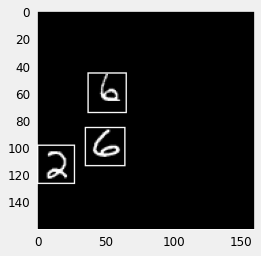

In [19]:
img = draw_bounding_boxes_on_image_array(255*images[0].reshape(NEW_IMG_SIZE, NEW_IMG_SIZE), boxes=bboxes[0], color='red')
plt.imshow(img)
plt.imsave("example.png", img)

## Writing a custom dataset

Let's output a dataset.

In [20]:
#images_wcanvac, train_bboxes
import cv2
import pandas as pd
df = pd.DataFrame()

img_names = []
bboxes_list = []
label_list = []
for i, (img, bbox, label) in enumerate(zip(images, bboxes, labels)):
    
    #img = np.expand_dims(img, axis=1)
    print(img.shape)
    # im = Image.fromarray()
    img = (img * 255).astype('uint8')
    cv2.imwrite(f"images/{i}.png", img)
    
    img_names.append(f"images/{i}.png")
    bboxes_list.append(bbox)
    label_list.append(label)
    #im = Image.fromarray(np.uint8(img*255), 'L')

    print(i)
    
df["image_path"] = img_names
df["bboxes"] = bboxes_list
df["label"] = label_list
    

(160, 160, 1)
0
(160, 160, 1)
1
(160, 160, 1)
2
(160, 160, 1)
3
(160, 160, 1)
4
(160, 160, 1)
5
(160, 160, 1)
6
(160, 160, 1)
7
(160, 160, 1)
8
(160, 160, 1)
9
(160, 160, 1)
10
(160, 160, 1)
11
(160, 160, 1)
12
(160, 160, 1)
13
(160, 160, 1)
14
(160, 160, 1)
15
(160, 160, 1)
16
(160, 160, 1)
17
(160, 160, 1)
18
(160, 160, 1)
19
(160, 160, 1)
20
(160, 160, 1)
21
(160, 160, 1)
22
(160, 160, 1)
23
(160, 160, 1)
24
(160, 160, 1)
25
(160, 160, 1)
26
(160, 160, 1)
27
(160, 160, 1)
28
(160, 160, 1)
29
(160, 160, 1)
30
(160, 160, 1)
31
(160, 160, 1)
32
(160, 160, 1)
33
(160, 160, 1)
34
(160, 160, 1)
35
(160, 160, 1)
36
(160, 160, 1)
37
(160, 160, 1)
38
(160, 160, 1)
39
(160, 160, 1)
40
(160, 160, 1)
41
(160, 160, 1)
42
(160, 160, 1)
43
(160, 160, 1)
44
(160, 160, 1)
45
(160, 160, 1)
46
(160, 160, 1)
47
(160, 160, 1)
48
(160, 160, 1)
49
(160, 160, 1)
50
(160, 160, 1)
51
(160, 160, 1)
52
(160, 160, 1)
53
(160, 160, 1)
54
(160, 160, 1)
55
(160, 160, 1)
56
(160, 160, 1)
57
(160, 160, 1)
58
(160, 1

In [21]:
df

,image_path,bboxes,label
0,images/0.png,"[[0.225, 0.53125, 0.4, 0.70625], [0.0, 0.61875...","[6, 2, 6]"
1,images/1.png,"[[0.55, 0.51875, 0.725, 0.69375], [0.325, 0.21...","[1, 9, 4]"
2,images/2.png,"[[0.15, 0.55625, 0.325, 0.73125], [0.0625, 0.3...","[3, 9, 8]"
3,images/3.png,"[[0.16875, 0.55625, 0.34375, 0.73125], [0.5187...","[2, 0, 9]"
4,images/4.png,"[[0.36875, 0.0125, 0.54375, 0.1875], [0.6375, ...","[4, 3, 7]"
...,...,...,...
195,images/195.png,"[[0.0875, 0.61875, 0.2625, 0.79375], [0.79375,...","[4, 9, 8]"
196,images/196.png,"[[0.76875, 0.55625, 0.94375, 0.73125], [0.0812...","[3, 3, 6]"
197,images/197.png,"[[0.625, 0.5125, 0.8, 0.6875], [0.19375, 0.562...","[6, 9, 0]"
198,images/198.png,"[[0.6875, 0.61875, 0.8625, 0.79375], [0.58125,...","[6, 2, 4]"


In [22]:
df.to_pickle("annotations.pkl")
df.to_csv("annotations.csv")
df.to_json("annotations.json")
